# Data Science 2 - ESEO DSMT - Cyrielle Albert

## Time Series Analysis: Sine Frequency Prediction 


**1.** Load Matlab simulated data: DataSinFreq (data size?).\
**2.** Split data into TRAIN and TEST.\
**3.** Apply PCA for dimension reduction to the TRAIN and TEST data.\
**3.1** Plot the first component in function of the second one for TRAIN-TEST PCA transformed      data. ATTENTION: make sure that they belong to the same space.\
**4.** Use CrossValidation within all REGRESSION models you studied in S8-S9 (linear models, linear with penalties, CART, SVR, ensemble learning...) and select the best one.\
**4.1** Apply TUNING and/or EARLY STOPPING (if available) to the selected model if necessary.\
**5.** Train and print the score for the final model.\
**6.** Load measurements data: measSinFreq (data size?).\
**7.** Apply PCA for dimension reduction to measurements data.\
**7.1** Plot the first component in function of the second one for the measurements PCA transformed data. ATTENTION: make sure that they belong to the same space plotted in **3.1**
 
**8.** Use the model obtained in **5** to make your frequency prediction

### 1. Load Matlab Simulated data DataSinFreq

In [1]:
import scipy.io as scio

data = scio.loadmat(r'DataSinFreq.mat')
print(data.keys()) # Display the informations contained in data 

dict_keys(['__header__', '__version__', '__globals__', 'X', 'target'])


#### 1 1.1 Visualisation des données

In [2]:
X = data['X'] #Time-series representing discrete sinusoids
y = data['target'] #Gives the frequency of each sinusoid
print("Nombre d'observations: ",X.shape[0])
print("Nombre de features: ",X.shape[1])
print("Shape target: ",y.shape )

Nombre d'observations:  900
Nombre de features:  500
Shape target:  (900, 1)


In [3]:
#Check if there are nan values
import numpy as np
arr = np.sum(X)
is_nan = np.isnan(arr)
print(is_nan) #False if no NaN values in the data.


False


In [4]:
import matplotlib.pyplot as plt

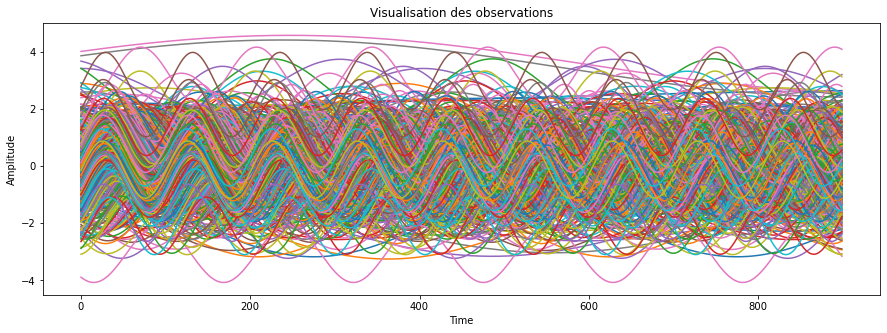

In [5]:
plt.figure(figsize=(15,5))
plt.plot(X[:,:]);
plt.title("Visualisation des observations");
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


### 2. Split data into TRAIN and TEST.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0,test_size=0.2)

### 3. Apply PCA for dimension reduction to the TRAIN and TEST data.

In [8]:
preprocessor = make_pipeline(StandardScaler(),PCA(n_components = 0.99,random_state=0))

In [9]:
X_train_pca = preprocessor.fit_transform(X_train,y_train)
X_test_pca = preprocessor.transform(X_test)
print("Nombre de nouvelles composantes: ",X_train_pca.shape[1])


Nombre de nouvelles composantes:  18


#### 3.1 Plot the first component in function of the second one for TRAIN-TEST PCA transformed data. ATTENTION: make sure that they belong to the same space.

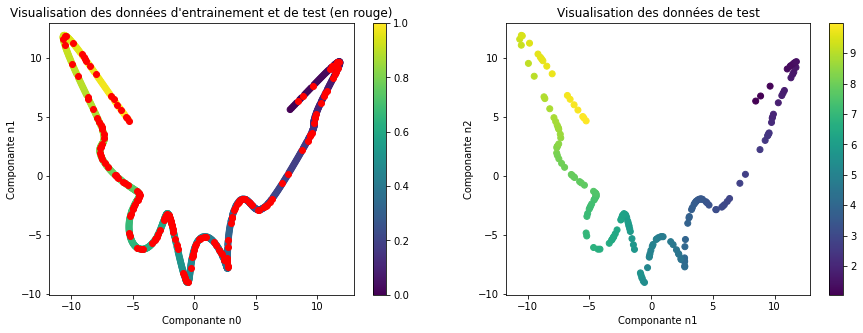

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(121)
CompInit = 0
CompFinal = 1
plt.scatter(X_train_pca[:,CompInit],X_train_pca[:,CompFinal],c = y_train);
plt.scatter(X_test_pca[:,CompInit],X_test_pca[:,CompFinal],c='r')
plt.colorbar();
plt.title("Visualisation des données d'entrainement et de test (en rouge)")
plt.xlabel("Componante n{0}".format(CompInit));
plt.ylabel("Componante n{0}".format(CompFinal));

plt.subplot(122)
plt.scatter(X_test_pca[:,CompInit],X_test_pca[:,CompFinal],c =y_test);
plt.colorbar();
plt.title("Visualisation des données de test")
plt.xlabel("Componante n{0}".format(CompInit+1));
plt.ylabel("Componante n{0}".format(CompFinal+1));

#### Observation :
On the first plot, we can see both the training data transformed in the new space created by the PCA, and the test data in red.
We can see that the test data were successfully transformed to the new space as all values are plot on the same space as the training data.

On the second plot, we can see that the targeted values of the test data are coherent with the targeted values of the training data.

### 4. Use CrossValidation within all REGRESSION models you studied in S8-S9 (linear models, linear with penalties, CART, SVR, ensemble learning...) and select the best one.

In [11]:
from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor 
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [12]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning

In [13]:
seed = 0
models = []
models.append(('LR',LinearRegression()))
models.append(('Ridge',Ridge(random_state=seed)))
models.append(('Lasso',Lasso(random_state=seed)))
models.append(('ElasticNet',ElasticNet(random_state=seed)))
models.append(("SVR",SVR()))
models.append(("CART",DecisionTreeRegressor(random_state=seed)))
models.append(("K-Neighbor",KNeighborsRegressor()))


In [14]:
pipelines_ensemble = []
pipelines_ensemble.append(("Voting",VotingRegressor(models)))
pipelines_ensemble.append(("Bagging",BaggingRegressor(DecisionTreeRegressor(random_state=seed))))
pipelines_ensemble.append(("RandomForest",RandomForestRegressor(random_state=seed)))
pipelines_ensemble.append(("ExtraTrees",ExtraTreesRegressor(random_state=seed)))
pipelines_ensemble.append(("Adaboost",AdaBoostRegressor(random_state=seed)))
pipelines_ensemble.append(("GradientBoost",GradientBoostingRegressor(random_state=seed)))
pipelines_ensemble.append(("Stacking",StackingRegressor(models,final_estimator=KNeighborsRegressor())))
pipelines_ensemble.append(("XGBoost",XGBRegressor(random_state=seed)))
pipelines_ensemble.append(("LightGBM",LGBMRegressor(random_state=seed)))

In [15]:
pipelines = models + pipelines_ensemble

In [16]:
import warnings
warnings.filterwarnings("ignore", category=DataConversionWarning)

In [17]:
results=[]
names=[]
num_folds=5
scoring='r2'

for name, model in pipelines:
    kfold=KFold(n_splits=num_folds)
    cv_results=cross_val_score(model, X_train_pca,y_train,cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name,cv_results.mean(),cv_results.std())
    print(msg)


LR: 0.996901 (0.000730)
Ridge: 0.996901 (0.000730)
Lasso: 0.969227 (0.005641)
ElasticNet: 0.982749 (0.003608)
SVR: 0.998495 (0.000167)
CART: 0.998047 (0.002793)
K-Neighbor: 0.999984 (0.000006)
Voting: 0.996888 (0.000891)
Bagging: 0.999247 (0.001332)
RandomForest: 0.999260 (0.001376)
ExtraTrees: 0.999963 (0.000062)
Adaboost: 0.996264 (0.001254)
GradientBoost: 0.999798 (0.000150)
Stacking: 0.999823 (0.000273)
XGBoost: 0.999687 (0.000216)
LightGBM: 0.999772 (0.000248)


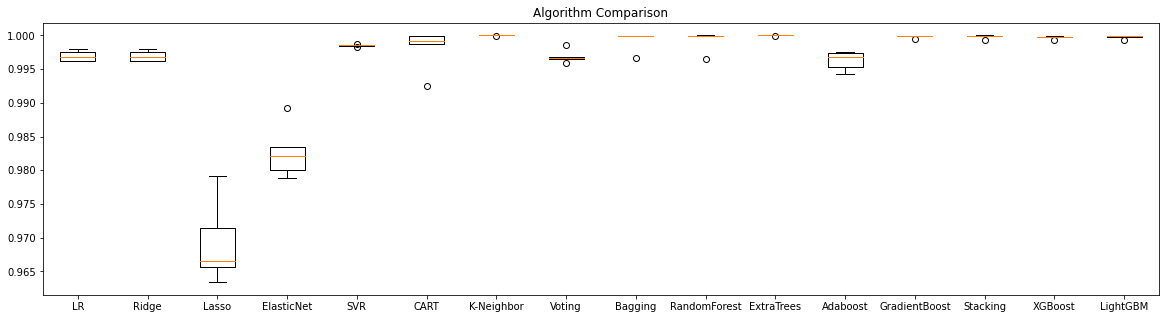

In [18]:
plt.figure(figsize=(20,5))
plt.boxplot(results);
tick = [i for i in range(1,len(names)+1)]
plt.xticks(tick,names);
plt.title('Algorithm Comparison');

#### Observation :

The cross-validation reflects that few algorithms are on the average better than others for this regression problem. Even though all models scored a coefficient of determination close to 1, few of them returned better results. For the tuning part which comes next, I have decided to choose 3 differents models that gave the best results, the **K-Neighbor Regressor**, the **Extra Trees Regressor** and the **LGBM Regressor**.

### 4.1 Apply TUNING and/or EARLY STOPPING (if available) to the selected model if necessary.

#### 4.1.1 Tuning on the K-Neighbor Regressor

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
model = KNeighborsRegressor()

In [21]:
param_grid = {
    "n_neighbors":[5,6,7,8,9],
    "weights": ['uniform','distance'],
    "algorithm":["auto","ball_tree","kd_tree","brute"],
    "leaf_size":[1,5,10,20,30,40,50]
}

In [22]:
y_hat_grid = GridSearchCV(model,param_grid,scoring='r2',cv=10)
y_hat_grid.fit(X_train_pca,y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 5, 10, 20, 30, 40, 50],
                         'n_neighbors': [5, 6, 7, 8, 9],
                         'weights': ['uniform', 'distance']},
             scoring='r2')

In [23]:
print("Score du meilleur modèle: ",y_hat_grid.best_score_)

Score du meilleur modèle:  0.9999946098703285


In [24]:
print("Hyperparametres du meilleur modèle: ",y_hat_grid.best_params_)

Hyperparametres du meilleur modèle:  {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 6, 'weights': 'distance'}


#### 4.1.2 Tuning on the Extratrees Regressor 

In [25]:
from sklearn.model_selection import RandomizedSearchCV

In [26]:
model = ExtraTreesRegressor(random_state=0,)

In [27]:
n_pca_features = X_train_pca.shape[1]
n_observation = X_train_pca.shape[0]
param_grid={
    "n_estimators": range(1,20),
    "max_features": range(1,n_pca_features),
    "min_samples_split":range(1,n_observation)
    
}

In [28]:
y_hat_grid_2 = RandomizedSearchCV(model,param_grid,scoring='r2',cv=10,n_iter=20,random_state=seed)
y_hat_grid_2.fit(X_train_pca,y_train)

RandomizedSearchCV(cv=10, estimator=ExtraTreesRegressor(random_state=0),
                   n_iter=20,
                   param_distributions={'max_features': range(1, 18),
                                        'min_samples_split': range(1, 720),
                                        'n_estimators': range(1, 20)},
                   random_state=0, scoring='r2')

In [29]:
print("Score du meilleur modèle: ",y_hat_grid_2.best_score_)

Score du meilleur modèle:  0.9992503850621978


In [30]:
print("Hyperparametres du meilleur modèle: ",y_hat_grid_2.best_params_)

Hyperparametres du meilleur modèle:  {'n_estimators': 9, 'min_samples_split': 17, 'max_features': 8}


#### 4.1.3 Early Stopping & Tuning on LGBM Regressor

In [31]:
model = LGBMRegressor(n_estimators=10000,random_state=seed)
eval_set = [(X_test_pca,y_test)]
model.fit(X_train_pca,y_train,eval_metric="r2",early_stopping_rounds=20,eval_set=eval_set,verbose=True)

print(model.score(X_test_pca,y_test))

[1]	valid_0's l2: 5.30396
[2]	valid_0's l2: 4.30758
[3]	valid_0's l2: 3.49554
[4]	valid_0's l2: 2.83897
[5]	valid_0's l2: 2.30506
[6]	valid_0's l2: 1.86797
[7]	valid_0's l2: 1.51564
[8]	valid_0's l2: 1.23166
[9]	valid_0's l2: 1.00136
[10]	valid_0's l2: 0.814001
[11]	valid_0's l2: 0.662215
[12]	valid_0's l2: 0.537711
[13]	valid_0's l2: 0.437325
[14]	valid_0's l2: 0.356187

D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
D:\Anaconda\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')



[15]	valid_0's l2: 0.289825
[16]	valid_0's l2: 0.236184
[17]	valid_0's l2: 0.192877
[18]	valid_0's l2: 0.157315
[19]	valid_0's l2: 0.128745
[20]	valid_0's l2: 0.105468
[21]	valid_0's l2: 0.0864709
[22]	valid_0's l2: 0.0709843
[23]	valid_0's l2: 0.0584702
[24]	valid_0's l2: 0.0482557
[25]	valid_0's l2: 0.0398998
[26]	valid_0's l2: 0.033137
[27]	valid_0's l2: 0.0275301
[28]	valid_0's l2: 0.0229802
[29]	valid_0's l2: 0.0192747
[30]	valid_0's l2: 0.0162964
[31]	valid_0's l2: 0.0138264
[32]	valid_0's l2: 0.0118132
[33]	valid_0's l2: 0.0101728
[34]	valid_0's l2: 0.00881153
[35]	valid_0's l2: 0.00769646
[36]	valid_0's l2: 0.00678779
[37]	valid_0's l2: 0.00602697
[38]	valid_0's l2: 0.00541476
[39]	valid_0's l2: 0.00490395
[40]	valid_0's l2: 0.0044704
[41]	valid_0's l2: 0.00411324
[42]	valid_0's l2: 0.00381546
[43]	valid_0's l2: 0.00356707
[44]	valid_0's l2: 0.00337024
[45]	valid_0's l2: 0.00320712
[46]	valid_0's l2: 0.00305468
[47]	valid_0's l2: 0.00292543
[48]	valid_0's l2: 0.00281979
[49]	v

[337]	valid_0's l2: 0.00162743
[338]	valid_0's l2: 0.00162668
[339]	valid_0's l2: 0.00162601
[340]	valid_0's l2: 0.00162553
[341]	valid_0's l2: 0.00162507
[342]	valid_0's l2: 0.0016249
[343]	valid_0's l2: 0.00162473
[344]	valid_0's l2: 0.00162535
[345]	valid_0's l2: 0.00162528
[346]	valid_0's l2: 0.00162499
[347]	valid_0's l2: 0.00162431
[348]	valid_0's l2: 0.00162403
[349]	valid_0's l2: 0.00162406
[350]	valid_0's l2: 0.00162342
[351]	valid_0's l2: 0.00162336
[352]	valid_0's l2: 0.00162322
[353]	valid_0's l2: 0.00162319
[354]	valid_0's l2: 0.00162273
[355]	valid_0's l2: 0.0016222
[356]	valid_0's l2: 0.00162126
[357]	valid_0's l2: 0.00162091
[358]	valid_0's l2: 0.00162055
[359]	valid_0's l2: 0.00162021
[360]	valid_0's l2: 0.00161988
[361]	valid_0's l2: 0.00161941
[362]	valid_0's l2: 0.0016194
[363]	valid_0's l2: 0.00161926
[364]	valid_0's l2: 0.0016184
[365]	valid_0's l2: 0.00161807
[366]	valid_0's l2: 0.00161774
[367]	valid_0's l2: 0.00161822
[368]	valid_0's l2: 0.0016177
[369]	valid_0

[612]	valid_0's l2: 0.00156341
[613]	valid_0's l2: 0.00156324
[614]	valid_0's l2: 0.00156311
[615]	valid_0's l2: 0.00156274
[616]	valid_0's l2: 0.00156269
[617]	valid_0's l2: 0.00156267
[618]	valid_0's l2: 0.00156278
[619]	valid_0's l2: 0.00156245
[620]	valid_0's l2: 0.00156239
[621]	valid_0's l2: 0.00156227
[622]	valid_0's l2: 0.00156217
[623]	valid_0's l2: 0.00156213
[624]	valid_0's l2: 0.00156188
[625]	valid_0's l2: 0.00156165
[626]	valid_0's l2: 0.0015617
[627]	valid_0's l2: 0.00156159
[628]	valid_0's l2: 0.00156153
[629]	valid_0's l2: 0.00156146
[630]	valid_0's l2: 0.00156135
[631]	valid_0's l2: 0.00156131
[632]	valid_0's l2: 0.00156107
[633]	valid_0's l2: 0.00156083
[634]	valid_0's l2: 0.00156048
[635]	valid_0's l2: 0.00156045
[636]	valid_0's l2: 0.0015604
[637]	valid_0's l2: 0.00156024
[638]	valid_0's l2: 0.0015601
[639]	valid_0's l2: 0.00155987
[640]	valid_0's l2: 0.00155984
[641]	valid_0's l2: 0.00155978
[642]	valid_0's l2: 0.00155972
[643]	valid_0's l2: 0.00155955
[644]	valid

[946]	valid_0's l2: 0.00152844
[947]	valid_0's l2: 0.0015284
[948]	valid_0's l2: 0.00152834
[949]	valid_0's l2: 0.00152836
[950]	valid_0's l2: 0.00152828
[951]	valid_0's l2: 0.00152817
[952]	valid_0's l2: 0.00152805
[953]	valid_0's l2: 0.00152802
[954]	valid_0's l2: 0.00152807
[955]	valid_0's l2: 0.00152795
[956]	valid_0's l2: 0.00152793
[957]	valid_0's l2: 0.00152788
[958]	valid_0's l2: 0.00152784
[959]	valid_0's l2: 0.00152778
[960]	valid_0's l2: 0.00152775
[961]	valid_0's l2: 0.00152774
[962]	valid_0's l2: 0.00152776
[963]	valid_0's l2: 0.00152772
[964]	valid_0's l2: 0.00152765
[965]	valid_0's l2: 0.00152766
[966]	valid_0's l2: 0.00152755
[967]	valid_0's l2: 0.00152748
[968]	valid_0's l2: 0.00152738
[969]	valid_0's l2: 0.00152737
[970]	valid_0's l2: 0.00152727
[971]	valid_0's l2: 0.00152721
[972]	valid_0's l2: 0.00152723
[973]	valid_0's l2: 0.00152719
[974]	valid_0's l2: 0.00152716
[975]	valid_0's l2: 0.00152694
[976]	valid_0's l2: 0.00152688
[977]	valid_0's l2: 0.00152682
[978]	val

[1242]	valid_0's l2: 0.00151944
[1243]	valid_0's l2: 0.00151949
[1244]	valid_0's l2: 0.00151945
[1245]	valid_0's l2: 0.00151945
[1246]	valid_0's l2: 0.00151948
[1247]	valid_0's l2: 0.00151946
[1248]	valid_0's l2: 0.00151949
[1249]	valid_0's l2: 0.00151946
[1250]	valid_0's l2: 0.00151942
[1251]	valid_0's l2: 0.00151945
[1252]	valid_0's l2: 0.0015195
[1253]	valid_0's l2: 0.00151946
[1254]	valid_0's l2: 0.00151941
[1255]	valid_0's l2: 0.00151939
[1256]	valid_0's l2: 0.0015194
[1257]	valid_0's l2: 0.0015194
[1258]	valid_0's l2: 0.00151937
[1259]	valid_0's l2: 0.00151937
[1260]	valid_0's l2: 0.00151936
[1261]	valid_0's l2: 0.00151934
[1262]	valid_0's l2: 0.00151936
[1263]	valid_0's l2: 0.00151931
[1264]	valid_0's l2: 0.00151935
[1265]	valid_0's l2: 0.00151932
[1266]	valid_0's l2: 0.00151937
[1267]	valid_0's l2: 0.00151941
[1268]	valid_0's l2: 0.00151936
[1269]	valid_0's l2: 0.00151933
[1270]	valid_0's l2: 0.0015193
[1271]	valid_0's l2: 0.00151928
[1272]	valid_0's l2: 0.00151927
[1273]	valid

In [32]:
print(model.best_score_)
print(model.best_iteration_)

defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('l2', 0.0015191428367818992)])})
1291


 There isn't much difference in the score after 100 estimations so we can choose N_estimators = 100


In [34]:
model = LGBMRegressor(n_estimators=100,random_state=seed)


In [35]:
param_grid = {
    "boosting_type":['gbdt','rf'],
    'max_depth':[4,6,8,10],
    'scale_pos_weight':[1,3,5],
    'subsample':[0.5,0.75,1],
    'colsample_bytree':[0.4,0.6,0.8,1],
    'learning_rate':[0.01,0.05,0.1],
    'min_child_weight':[1,3,5],
    "subsample_for_bin":[2000000]
}

In [36]:
y_hat_grid_3 = RandomizedSearchCV(model, param_grid,scoring='r2',cv=10,n_iter=20,random_state=seed)
y_hat_grid_3.fit(X_train_pca,y_train,eval_metric='r2')

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "D:\Anaconda\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "D:\Anaconda\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "D:\Anaconda\lib\site-packages\lightgbm\basic.py", line 2610, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "D:\Anaconda\lib\site-packages\lightgbm\basic.py", line 125, in _safe_call
    raise 

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "D:\Anaconda\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "D:\Anaconda\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "D:\Anaconda\lib\site-packages\lightgbm\basic.py", line 2610, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "D:\Anaconda\lib\site-packages\lightgbm\basic.py", line 125, in _safe_call
    raise 

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "D:\Anaconda\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "D:\Anaconda\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "D:\Anaconda\lib\site-packages\lightgbm\basic.py", line 2610, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "D:\Anaconda\lib\site-packages\lightgbm\basic.py", line 125, in _safe_call
    raise 

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "D:\Anaconda\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "D:\Anaconda\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "D:\Anaconda\lib\site-packages\lightgbm\basic.py", line 2610, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "D:\Anaconda\lib\site-packages\lightgbm\basic.py", line 125, in _safe_call
    raise 

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "D:\Anaconda\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "D:\Anaconda\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "D:\Anaconda\lib\site-packages\lightgbm\basic.py", line 2610, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "D:\Anaconda\lib\site-packages\lightgbm\basic.py", line 125, in _safe_call
    raise 

D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "D:\Anaconda\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "D:\Anaconda\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "D:\Anaconda\lib\site-packages\lightgbm\basic.py", line 2610, in __init__
    _safe_call(_LIB.LGBM_BoosterCreate(
  File "D:\Anaconda\lib\site-packages\lightgbm\basic.py", line 125, in _safe_call
    raise 

RandomizedSearchCV(cv=10, estimator=LGBMRegressor(random_state=0), n_iter=20,
                   param_distributions={'boosting_type': ['gbdt', 'rf'],
                                        'colsample_bytree': [0.4, 0.6, 0.8, 1],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [4, 6, 8, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'scale_pos_weight': [1, 3, 5],
                                        'subsample': [0.5, 0.75, 1],
                                        'subsample_for_bin': [2000000]},
                   random_state=0, scoring='r2')

In [37]:
print("Score du meilleur modèle: ",y_hat_grid_3.best_score_)
print("Hyperparametres du meilleur modèle: ",y_hat_grid_3.best_params_)

Score du meilleur modèle:  0.9983373757477398
Hyperparametres du meilleur modèle:  {'subsample_for_bin': 2000000, 'subsample': 0.75, 'scale_pos_weight': 5, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt'}


### Observation:  
I have tuned 3 different models and the model that gave the best results is the **K-Neighbor Regressor**. 

All models scored significantly close to 1 so they are all **valuable models** to use but, the **LightGBM Regressor** was more time-consuming (and thus expensive) to tune and train. 

### 5. Train and print the score for the final model.

In [38]:
final_model = KNeighborsRegressor(algorithm="auto",leaf_size=1,n_neighbors=6,weights="distance")

In [39]:
final_model.fit(X_train_pca,y_train)

KNeighborsRegressor(leaf_size=1, n_neighbors=6, weights='distance')

In [40]:
print(final_model.score(X_test_pca,y_test))

0.9999959860255883


### 6. Load measurements data: measSinFreq (data size?).

In [41]:
validation_data = scio.loadmat(r'measSinFreq.mat')
print(type(validation_data))

<class 'dict'>


In [42]:
print(validation_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'y'])


In [43]:
X_validation = validation_data['y']
print(y.shape)

(900, 1)


### 7. Apply PCA for dimension reduction to measurements data.

In [44]:
X_validation_pca = preprocessor.transform(X_validation)

#### 7.1 Plot the first component in function of the second one for the measurements PCA transformed data. ATTENTION: make sure that they belong to the same space plotted in 3.1

Text(0, 0.5, 'Componante n1')

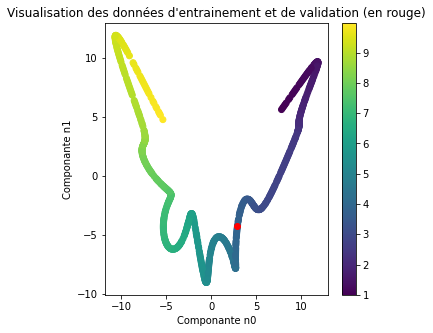

In [45]:
plt.figure(figsize=(5,5))
CompInit = 0
CompFinal = 1
plt.scatter(X_train_pca[:,CompInit],X_train_pca[:,CompFinal],c = y_train);
plt.scatter(X_validation_pca[:,CompInit],X_validation_pca[:,CompFinal],c='r')
plt.colorbar();
plt.clim(np.max(y_train))
plt.title("Visualisation des données d'entrainement et de validation (en rouge)")
plt.xlabel("Componante n{0}".format(CompInit))
plt.ylabel("Componante n{0}".format(CompFinal))

#### Observation : 
We can see that the measured data transformed with the PCA is in the same space as the training data. It shows that the PCA was successful.

### 8. Use the model obtained in 5 to make your frequency prediction

In [46]:
prediction = final_model.predict(X_validation_pca)

In [47]:
print("Prediction de la fréquence du signal: y={:.2f}".format(float(prediction)))

Prediction de la fréquence du signal: y=3.85
